In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [20]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.compose import ColumnTransformer

In [21]:
df = pd.read_csv("/content/train.csv" , usecols = ["Age","Fare","Survived"])
df["Age"].fillna(df["Age"].mean(),inplace = True)
df.head()

<ipython-input-21-9f5ad534de51>:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["Age"].fillna(df["Age"].mean(),inplace = True)


,Survived,Age,Fare
0,0,22.0,7.2500
1,1,38.0,71.2833
2,1,26.0,7.9250
3,1,35.0,53.1000
4,0,35.0,8.0500


In [22]:
df.shape

(891, 3)

In [23]:
X = df.iloc[:,1:]
y = df.iloc[:,0]

In [24]:
X_train  , X_test , y_train , y_test = train_test_split(X,y,test_size = 0.2,random_state = 42)

In [25]:
X_train.head()

,Age,Fare
331,45.5,28.5000
733,23.0,13.0000
382,32.0,7.9250
704,26.0,7.8542
813,6.0,31.2750


In [26]:
clf = DecisionTreeClassifier()
clf.fit(X_train,y_train)

DecisionTreeClassifier()

In [27]:
y_pred = clf.predict(X_test)

In [28]:
accuracy_score(y_test,y_pred)

0.6815642458100558

In [30]:
np.mean(cross_val_score(DecisionTreeClassifier(),X,y,cv = 10,scoring = "accuracy"))

0.6599500624219725

# **With Discretizer**

In [52]:
kbins_age = KBinsDiscretizer(n_bins = 15, encode = "ordinal" , strategy = "quantile")
kbins_fare = KBinsDiscretizer(n_bins = 15 , encode = "ordinal" , strategy = "quantile")

In [53]:
tfr = ColumnTransformer(
    transformers = [
        ("first" , kbins_age , [0]),
        ("second", kbins_fare , [1])
    ]
)

In [54]:
X_train_tfr = tfr.fit_transform(X_train)
X_test_tfr = tfr.transform(X_test)

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_discretization.py:307: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(


In [55]:
tfr.named_transformers_["first"].n_bins_

array([13])

In [56]:
tfr.named_transformers_["first"].bin_edges_

array([array([ 0.42      ,  8.4       , 18.        , 21.        , 23.        ,
              25.        , 28.        , 29.69911765, 31.        , 34.        ,
              38.        , 44.        , 51.        , 80.        ])            ],
      dtype=object)

In [57]:
output = pd.DataFrame({
    "age"  : X_train["Age"],
    "age_trf" : X_train_tfr[:,0],
    "fare" : X_train["Fare"],
    "fare_trf" : X_train_tfr[:,1]
})

In [58]:
output["age_labels"] = pd.cut(x = X_train["Age"] , bins = tfr.named_transformers_["first"].bin_edges_[0].tolist())
output["fare_labels"] = pd.cut(x = X_train["Fare"] , bins = tfr.named_transformers_["second"].bin_edges_[0].tolist())

In [59]:
clf = DecisionTreeClassifier()
clf.fit(X_train_tfr,y_train)

DecisionTreeClassifier()

In [60]:
y_pred = clf.predict(X_test_tfr)

In [61]:
y_pred[:5]

array([0, 0, 0, 1, 1])

In [62]:
accuracy_score(y_test,y_pred)

0.6312849162011173

In [65]:
X_tfr = tfr.fit_transform(X)
np.mean(cross_val_score(DecisionTreeClassifier(),X_tfr,y,cv = 10,scoring = "accuracy"))

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_discretization.py:307: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(


0.6532084893882646

# **Function for Discretization**

In [108]:
def discretization(bins , strategy , show_graph = False , show_data = False):
  kbins_age = KBinsDiscretizer(n_bins = bins , encode = "ordinal" , strategy = strategy)
  kbins_fare = KBinsDiscretizer(n_bins = bins , encode = "ordinal" , strategy = strategy)

  trf = ColumnTransformer(
      transformers = [
          ("first_column" , kbins_age , [0]),
          ("second_column" , kbins_fare , [1])
      ]
  )

  X_train_trf = trf.fit_transform(X_train)
  X_test_trf = trf.transform(X_test)

  clf = DecisionTreeClassifier()
  clf.fit(X_train_trf , y_train)
  y_pred = clf.predict(X_test_trf)

  print("Accuracy Score:",accuracy_score(y_test,y_pred))

  X_trf  = trf.fit_transform(X)
  print("Cross Validation Score:",
        np.mean(cross_val_score(DecisionTreeClassifier() , X_trf , y , cv = 10 , scoring = "accuracy")))


  X_train_trf = pd.DataFrame(X_train_trf , columns = ["Age" , "Fare"])
  X_test_trf = pd.DataFrame(X_test_trf , columns = ["Age" , "Fare"])
  age_labels = pd.cut(X_train["Age"] , bins = trf.named_transformers_["first_column"].bin_edges_[0].tolist())
  fare_labels = pd.cut(X_train["Fare"] , bins = trf.named_transformers_["second_column"].bin_edges_[0].tolist())
  if show_data:
    output = pd.DataFrame({
        "age" : X_train["Age"].values,
        "age_trf" : X_train_trf["Age"].values,
        "age_labels" : age_labels,
        "fare" : X_train["Fare"].values,
        "fare_trf" : X_train_trf["Fare"].values,
        "fare_labels" : fare_labels

    })
    print(output.sample(10))

  if show_graph:
    for col in X_train.columns:
      plt.figure(figsize =(10,5))
      ## Before Transformation
      plt.subplot(121)
      sns.histplot(X_train[col])
      plt.title(f"{col} Before Transformation")
      ## After Transformation
      plt.subplot(122)
      sns.histplot(X_train_trf[col] , color = "red")
      plt.title(f"{col} After Transformation")
      plt.show()






/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_discretization.py:307: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_discretization.py:307: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(


Accuracy Score: 0.6703910614525139
Cross Validation Score: 0.6902996254681647
           age  age_trf      age_labels      fare  fare_trf      fare_labels
245  44.000000      9.0    (40.5, 49.0]   90.0000      11.0  (80.0, 512.329]
681  27.000000      4.0    (25.0, 29.0]   76.7292      10.0   (52.369, 80.0]
550  17.000000      1.0    (14.0, 19.0]  110.8833      11.0  (80.0, 512.329]
334  29.699118      6.0  (29.0, 29.699]  133.6500      11.0  (80.0, 512.329]
797  31.000000      7.0  (29.699, 31.0]    8.6833       4.0    (8.662, 11.5]
308  30.000000      6.0  (29.699, 31.0]   24.0000       7.0   (20.525, 26.0]
775  18.000000      1.0    (14.0, 19.0]    7.7500       1.0    (7.25, 7.775]
251  29.000000      5.0    (25.0, 29.0]   10.4625       4.0    (8.662, 11.5]
106  21.000000      2.0    (19.0, 22.0]    7.6500       1.0    (7.25, 7.775]
383  35.000000      8.0    (31.0, 35.0]   52.0000       9.0   (31.0, 52.369]


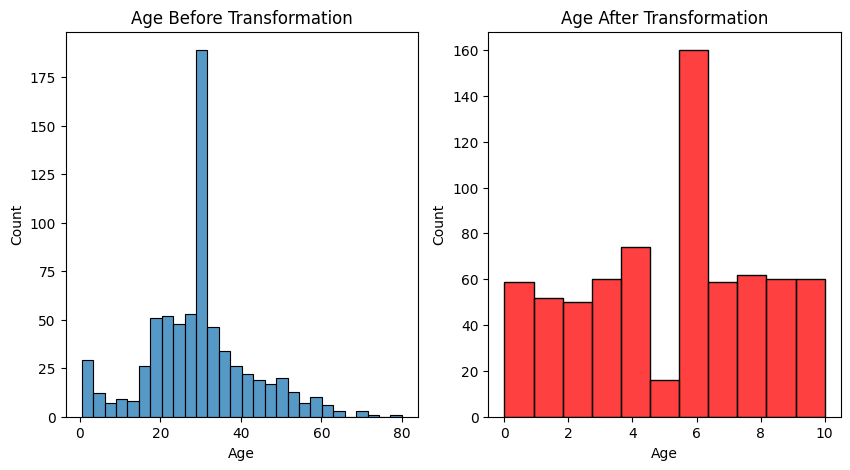

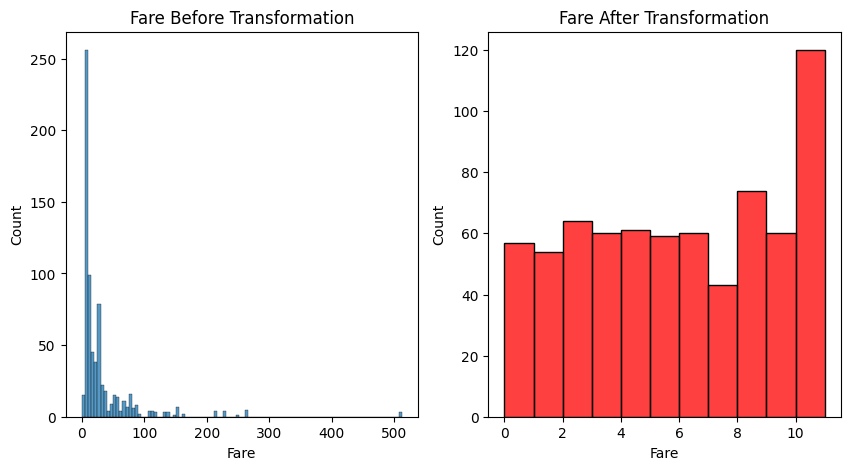

In [110]:
discretization(12 , "quantile" , show_data = True , show_graph = True)

Accuracy Score: 0.664804469273743
Cross Validation Score: 0.6959675405742821


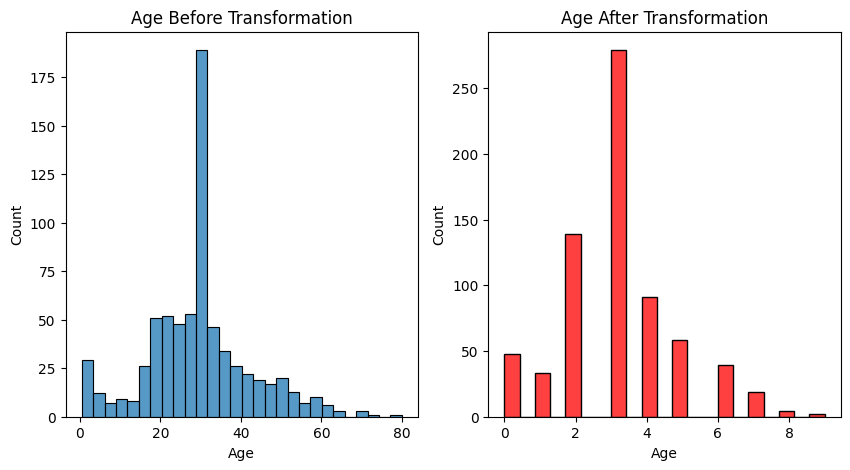

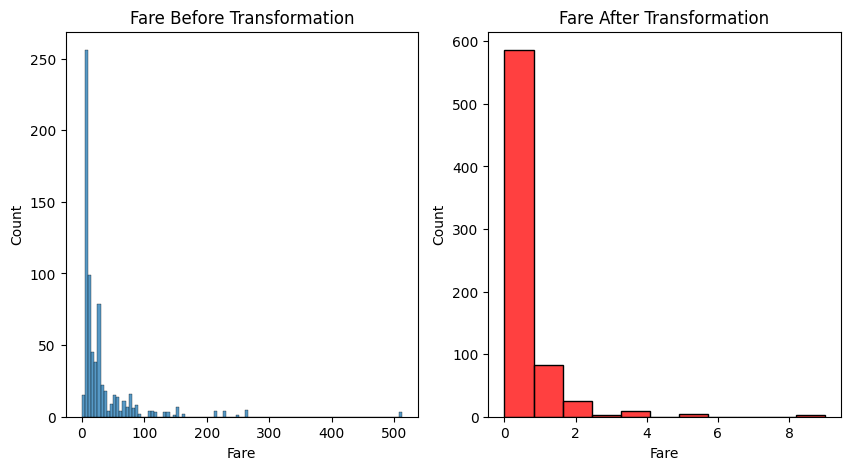

In [77]:
discretization(10 , "uniform")

Accuracy Score: 0.6424581005586593
Cross Validation Score: 0.6476779026217229


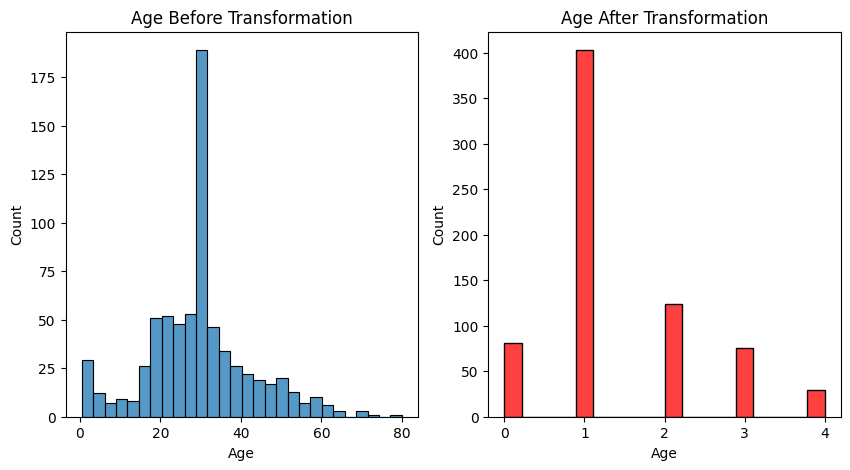

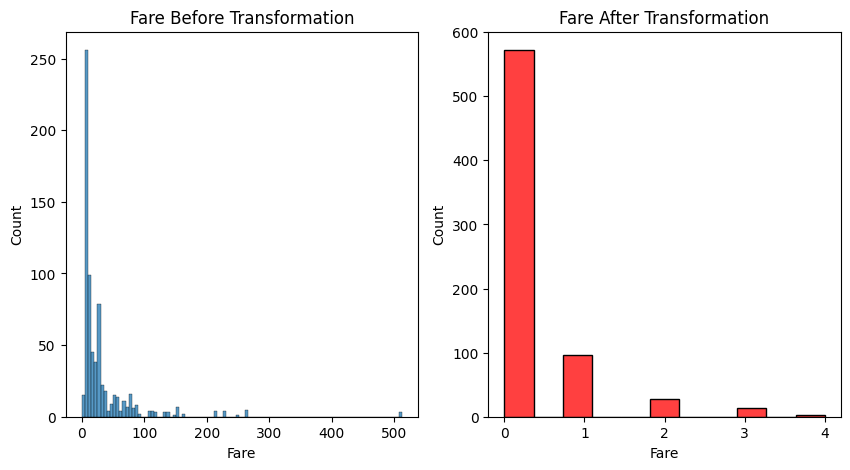

In [79]:
discretization(5 , "kmeans")